## Authors: Jiahao Sun, Congrong Ma, Xingyu Huang, Xiong Zhang, Zhen Gao

## Abstract
We tested two hypothesis on the Dataset of New York Times dataset and WallStreetBets dataset. 
- Hypothesis-1: The frequency of mentions of a corporate entity is uncorrelated with trading activity of that corporation's stock.
- Hypothesis-2: The sentiment of the discussion around a corporate entity is uncorrelated with the direction of movement in the related corporation's stock.

#### Hypothesis 1
We compared bert-base-ner model and Spacy(en-core-web-sm) model, and selected Spacy(en-core-web-sm) model.  
We used spearman correlation t test and KS test. We reject the null hypothesis in WSB dataset and accepted the null hypothesis in NYT dataset for all selected stocks given $1\%$ credential level.

#### Hypothesis 2
We compared zero-shot, Vader, finbert, and TextBlob models, and selected Vader and finbert model.  
For the hypothesis 2, we used spearman correlation t test, KS test, granger causality test, and Kruskal-Test. We accept the null hypothesis in both dataset for all selected stocks given $1\%$ credential level. 

## Methods and Data

### Hypothesis 1

#### i. Choose a Named Entity Recognition (NER) tool that is well suited for the specific dataset you are analyzing. You may want to try several and/or adjust the parameterization of the NER tool to see which performs the best.  
A: We choose the en_core_web_sm model in Spacy and bert_base_ner in transformers. Because these are the most common model in the NER field.


#### ii. Explain which technique the NER tool uses (e.g. word-list, HMM, CRF, CRF-LSTM hybrid, Transformer, etc.)  
A: 
The model en_core_web_sm used CNNs + CRF.  
The model bert_base_ner used BERT(Bidirectional Encoder Representations from Transformers).

#### iii. Explain why you found this to be a good tool-choice for each dataset.
A: In the end, we choose Spacy's en_core_web_sm model because bert_base_ner has some drawbacks.
The drawbacks of transformers are: 
- 1. It runs too slow. For Spacy, it takes no more than 10 minutes to get the NER results. But for transformers with model bert-base-ner, it takes about 5 hours. 
- 2. For transformers, it can select a charactor as entity. It's not suitable to use a charactor to match a company.

### Hypothesis 2
#### i. Choosing a Sentiment Analysis (SA) tool that is well suited for the specific dataset you are analyzing. You may want to try several and/or adjust the parameterization of the SA tool to see which performs the best.
A: WE chose TextBlob, Vader, zero-shot, fin-bert as our candidates.   
TextBlob is too simple to extract sentiment from financial news headlines accurately.  
Zero-shot runs too slow.  
Finally, we selected Vader and fin-bert.

#### ii. Explain which technique that SA tool uses
A: Vader and BERT.
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

#### iii. Explain why you found this to be a good tool-choice for each dataset.
A: We used some headlines as samples to test the accuracy of the models. And we found that these two models can extract sentiment from news headlines accurately in a resonable computational power.

## Implementation 

In [1]:
import itertools
import json
from pathlib import Path
from zipfile import ZipFile
import os
from tqdm import tqdm
import pandas as pd
import numpy as np


## NYTimes Dataset

In [2]:
# You'll need to change this to match where you've saved the short-cut to the class
# folder in your Google Drive.
# "C:\Users\xinyu\Desktop\Baruch learning\Semester2\MTH 9796 - Statistical Natural Language P\L3\drive-download-20220411T132035Z-001"

NYT_PATH = Path("Data\drive-download-20220411T132035Z-001")
assert NYT_PATH.exists(), f"Can't find {NYT_PATH}. Did you remember to mount your Google-Drive?"

In [3]:
NYT_files_num = len(os.listdir(NYT_PATH))
NYT_files_num

12

In [4]:
def iter_nytimes_docs(root):
  """Iterate over all doc" dictionaries in nyt news-story repository."""
  for path in root.glob("*.json"):
    dd = json.load(path.open())
    docs = dd['response']['docs']
    for doc in docs:
      yield doc

def extract_dated_headline(doc):
  """Extract just the (pub_date, headline)-tuple from a "doc" dictionary."""
  return (
      pd.Timestamp(doc['pub_date']),
      doc['headline']['main']
  )


# Show the first 5 articles in the repository
N = 5
ii = iter_nytimes_docs(NYT_PATH)
for _ in range(N):
  print(extract_dated_headline(next(ii)))

(Timestamp('2020-04-01 00:00:07+0000', tz='UTC'), 'Human Rights Group Says Two U.S. Strikes Killed Somali Civilians')
(Timestamp('2020-04-01 00:01:20+0000', tz='UTC'), '‘Never Thought I Would Need It’: Americans Put Pride Aside to Seek Aid')
(Timestamp('2020-04-01 00:43:34+0000', tz='UTC'), '$30 Million in Illegal Drugs Seized From Cross-Border Tunnel in San Diego, U.S. Says')
(Timestamp('2020-04-01 01:38:10+0000', tz='UTC'), 'As Furloughs Grow, Kennedy Center Defends Use of $25 Million in Aid')
(Timestamp('2020-04-01 02:00:03+0000', tz='UTC'), 'Historic Town in Veszprém County')


In [5]:
Date_list = []
Headline_list = []

for i,doc in enumerate(iter_nytimes_docs(NYT_PATH)):
    
    Date_list.append(str(doc['pub_date'])[:10])
    Headline_list.append(doc['headline']['main'])


nyt = pd.DataFrame({'created_utc_dt':Date_list,'title':Headline_list})
nyt

,created_utc_dt,title
0,2020-04-01,Human Rights Group Says Two U.S. Strikes Kille...
1,2020-04-01,‘Never Thought I Would Need It’: Americans Put...
2,2020-04-01,$30 Million in Illegal Drugs Seized From Cross...
3,2020-04-01,"As Furloughs Grow, Kennedy Center Defends Use ..."
4,2020-04-01,Historic Town in Veszprém County
...,...,...
57932,2021-03-31,Pitchers Beware: Giancarlo Stanton Is Feeling ...
57933,2021-03-31,‘Rebuild the Backbone of America’: Biden Unvei...
57934,2021-03-31,"Deaths, stillbirths and pregnancy complication..."
57935,2021-03-31,Biden and His Trillions


## WallStreetBets 

In [6]:
# You'll need to change this to match where you've saved the short-cut to the class
# folder in your Google Drive.
WSB_PATH = Path("Data\wsb-20200401_20210401-20220411T134036Z-001\wsb-20200401_20210401")
assert WSB_PATH.exists(), f"Can't find {WSB_PATH}. Did you remember to mount your Google-Drive?"

In [7]:

files_num = len(os.listdir(WSB_PATH))
# files_num = 10

In [8]:
def iter_wsb_dataframes(root):
  """Iterate over all wsb dataframes."""
  for path in root.glob("*.csv"):
    yield pd.read_csv(path, index_col=0)


# concat the first 10 wsb-CSVs into one big dataframe.
# ...this takes a while to run...
wsb25 = pd.concat(itertools.islice(iter_wsb_dataframes(WSB_PATH), files_num))

In [9]:
wsb25 = wsb25.sort_values('created_utc_dt',ascending=True).reset_index(drop=True)
wsb25

,author,created_utc,title,url,created,d_,created_utc_dt
0,CalculatedRoulette,1585693701,Pelosi : Bear Martyr Goddess,https://www.kqed.org/news/11803203/pelosi-lunc...,1.585694e+09,"{'author': 'CalculatedRoulette', 'created_utc'...",2020-03-31 22:28:21
1,Pokonic,1585693772,"Correct me if I'm wrong, but wouldn't any redu...",https://www.reddit.com/r/wallstreetbets/commen...,1.585694e+09,"{'author': 'Pokonic', 'created_utc': 158569377...",2020-03-31 22:29:32
2,toqueh,1585693799,What good is debt when daddy Jpow is just gonn...,https://thepeach.ca/?p=242053,1.585694e+09,"{'author': 'toqueh', 'created_utc': 1585693799...",2020-03-31 22:29:59
3,Chotothegoth,1585693800,The case for 70m unemployment in the us,https://www.reddit.com/r/wallstreetbets/commen...,1.585694e+09,"{'author': 'Chotothegoth', 'created_utc': 1585...",2020-03-31 22:30:00
4,lol558237,1585693851,Dont be a stubborn bull like me,https://i.redd.it/7az9p6cf43q41.jpg,1.585694e+09,"{'author': 'lol558237', 'created_utc': 1585693...",2020-03-31 22:30:51
...,...,...,...,...,...,...,...
1081129,MoRaLoSeVisH_13,1617235038,"Soon , fellow 🦍🦍🦍",https://i.redd.it/m8to12bkcgq61.jpg,1.617235e+09,"{'author': 'MoRaLoSeVisH_13', 'created_utc': 1...",2021-03-31 23:57:18
1081130,Electrozart,1617235042,Miley Cryus giving away $50 of free stock via ...,https://www.reddit.com/r/wallstreetbets/commen...,1.617235e+09,"{'author': 'Electrozart', 'created_utc': 16172...",2021-03-31 23:57:22
1081131,lexmark0331,1617235046,HOFV Mega squeeze Opportunity,https://i.redd.it/vca4pnalcgq61.jpg,1.617235e+09,"{'author': 'lexmark0331', 'created_utc': 16172...",2021-03-31 23:57:26
1081132,chefthmst1983,1617235173,So what happened end of day on the DOW...hell ...,https://i.redd.it/n3oh1tvycgq61.jpg,1.617235e+09,"{'author': 'chefthmst1983', 'created_utc': 161...",2021-03-31 23:59:33


## Downloading Stock Data

In [10]:
import yfinance
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

In [11]:
tsla = yfinance.download(['TSLA'], pd.Timestamp('2020-04-01'), pd.Timestamp('2021-04-01'), period="1d") 
tsla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,100.800003,102.790001,95.019997,96.311996,96.311996,66766000
2020-04-02,96.206001,98.851997,89.279999,90.893997,90.893997,99292000
2020-04-03,101.900002,103.098000,93.678001,96.001999,96.001999,112810500
2020-04-06,102.239998,104.199997,99.592003,103.248001,103.248001,74509000
2020-04-07,109.000000,113.000000,106.468002,109.089996,109.089996,89599000


In [12]:
traded_symbols = get_nasdaq_symbols()
traded_symbols.iloc[:,:4].head()

,Nasdaq Traded,Security Name,Listing Exchange,Market Category
Symbol,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,
AA,True,Alcoa Corporation Common Stock,N,
AAA,True,Listed Funds Trust AAF First Priority CLO Bond...,P,
AAAU,True,Goldman Sachs Physical Gold ETF Shares,Z,
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,


In [13]:
all_symbols = list(traded_symbols[~traded_symbols.ETF].index.unique())
all_securitynames = list(traded_symbols[~traded_symbols.ETF]['Security Name'].unique())

all_symbols[:10]

['A', 'AA', 'AAC', 'AAC.U', 'AAC.W', 'AACG', 'AACI', 'AACIU', 'AACIW', 'AADI']

In [14]:
all_securitynames[:10]

['Agilent Technologies, Inc. Common Stock',
 'Alcoa Corporation Common Stock ',
 'Ares Acquisition Corporation Class A Ordinary Shares',
 'Ares Acquisition Corporation Units, each consisting of one Class A ordinary share, and one-fifth of one redeemable warrant',
 'Ares Acquisition Corporation Redeemable Warrants, each whole warrant exercisable for one Class A ordinary share at an exercise price of $11.50',
 'ATA Creativity Global - American Depositary Shares, each representing two common shares',
 'Armada Acquisition Corp. I - Common Stock',
 'Armada Acquisition Corp. I - Unit',
 'Armada Acquisition Corp. I - Warrant',
 'Aadi Bioscience, Inc. - Common Stock']

## 2. Test-Hypothesis-1 

### a. Produce a time-series of (publication-time, entity-name)-tuples:

#### i. Choose a Named Entity Recognition (NER) tool that is well suited for the specific dataset you are analyzing. You may want to try several and/or adjust the parameterization of the NER tool to see which performs the best.  
A: We choose the en_core_web_sm model in Spacy and bert_base_ner in transformers. Because these are the most common model in the NER field.


#### ii. Explain which technique the NER tool uses (e.g. word-list, HMM, CRF, CRF-LSTM hybrid, Transformer, etc.)  
A: 
The model en_core_web_sm used CNNs + CRF.  
The model bert_base_ner used BERT(Bidirectional Encoder Representations from Transformers).

#### iii. Explain why you found this to be a good tool-choice for each dataset.
A: In the end, we choose Spacy's en_core_web_sm model because bert_base_ner has some drawbacks.
The drawbacks of transformers are: 
- 1. It runs too slow. For Spacy, it takes no more than 10 minutes to get the NER results. But for transformers with model bert-base-ner, it takes about 5 hours. 
- 2. For transformers, it can select a charactor as entity. It's not suitable to use a charactor to match a company.


### NER Tool 1: Spacy, en_core_web_sm

In [15]:
from textacy.extract import entities

import spacy
from spacy import displacy


##### run in anaconda

%%bash
python -m spacy download en_core_web_sm


In [16]:
nlp = spacy.load('en_core_web_sm') 

Example

In [17]:
sample_text = wsb25.loc[2,'title']
sample_text

'What good is debt when daddy Jpow is just gonna step in &amp; pay off everything'

In [257]:
doc = nlp(sample_text)

In [258]:
displacy.render(doc, style='ent', jupyter=True)

In [259]:
[(e.text,e.label_) for e in entities(doc)]

[('Jpow', 'PERSON'), ('&', 'ORG')]

In [260]:
spacy.explain("ORG"), spacy.explain("MONEY"), spacy.explain('PRODUCT')

('Companies, agencies, institutions, etc.',
 'Monetary values, including unit',
 'Objects, vehicles, foods, etc. (not services)')

use entity recognition method to identify entity in titles

In [22]:
def recognize_entity(df, re_method=entities):

    entity_list = []
    entity_label_list = []
    datetime_list = []

    for index in tqdm(df.index):
        # print(df.loc[index, 'created_utc_dt'])
        datetime = df.loc[index, 'created_utc_dt'].split(' ')[0]
        doc = nlp(df.loc[index, 'title'])
        # print(datetime, doc)
        
    # for index, row in tqdm(wsb25.iterrows()):
        # datetime = row['created_utc_dt'].split(' ')[0]
        # doc = nlp(row['title'])

        for entity in re_method(doc):
            entity_list.append(entity.text)
            entity_label_list.append(entity.label_)
            datetime_list.append(datetime)

    return pd.DataFrame({'Entity': entity_list, 'Entity_label': entity_label_list, 'Date': datetime_list})


```entities``` has ```text``` and ```label_``` attributes

In [23]:
df_nyt_entity = recognize_entity(nyt, entities)
df_nyt_entity = df_nyt_entity[df_nyt_entity['Entity_label'].isin(['ORG','PRODUCT'])]

df_nyt_entity.head()


100%|██████████| 57937/57937 [03:00<00:00, 321.73it/s]


,Entity,Entity_label,Date
0,Human Rights Group,ORG,2020-04-01
8,Kennedy Center Defends Use,ORG,2020-04-01
12,Trump Calls New Fuel Economy Rule a Boon,ORG,2020-04-01
16,Jazz Trumpet Virtuoso,ORG,2020-04-01
18,Coronavirus,ORG,2020-04-01


In [24]:
nyt_sorted_entity = df_nyt_entity.groupby(['Entity']).count().sort_values('Entity_label',ascending=False).reset_index().loc[:200,:]
nyt_sorted_entity.head(10)

# a lot of entities has nothing to do with corporation, need further selection

,Entity,Entity_label,Date
0,Trump,765,765
1,Coronavirus,430,430
2,Biden,411,411
3,Senate,239,239
4,House,233,233
5,White House,224,224
6,Dies,215,215
7,Supreme Court,201,201
8,N.Y.C.,118,118
9,Congress,116,116


In [25]:
from thefuzz import fuzz
from thefuzz import process

# https://github.com/seatgeek/thefuzz

C:\ProgramData\Anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


fuzz match entity to company name of NASDAQ

In [30]:
temp = nyt_sorted_entity['Entity'].apply(lambda x: process.extractOne(x, all_securitynames))
nyt_sorted_entity['fuzzmatch_name'] = temp.apply(lambda x: x[0])
nyt_sorted_entity['fuzzmatch_symbol'] = temp.apply(lambda x: traded_symbols[traded_symbols['Security Name']==x[0]].index[0])
nyt_sorted_entity['fuzzmatch_ratio'] = temp.apply(lambda x: x[1])
nyt_sorted_entity.sort_values(['fuzzmatch_ratio','Entity_label'],ascending=False).head(15)

,Entity,Entity_label,Date,fuzzmatch_name,fuzzmatch_symbol,fuzzmatch_ratio
4,House,233,233,"Full House Resorts, Inc. - Common Stock",FLL,90
15,Amazon,81,81,"Amazon.com, Inc. - Common Stock",AMZN,90
16,Capitol,64,64,"Capitol Federal Financial, Inc. - Common Stock",CFFN,90
18,Time,53,53,UTime Limited - Ordinary Shares,UTME,90
25,State,39,39,Allstate Corporation (The) Common Stock,ALL,90
27,Twitter,38,38,"Twitter, Inc. Common Stock",TWTR,90
31,Court,29,29,Newcourt Acquisition Corp - Unit,NCACU,90
35,New York Times,28,28,New York Times Company (The) Common Stock,NYT,90
37,Apple,27,27,Apple Inc. - Common Stock,AAPL,90
38,Vaccines,26,26,"Blue Water Vaccines, Inc. - Common Stock",BWV,90


In [31]:
nyt_selected_entities = ['Amazon','Capitol','Twitter','Boeing','Apple']

In [32]:
df_wsb_entity = recognize_entity(wsb25.sample(
    n=50000, replace=False, random_state=1), entities)
df_wsb_entity = df_wsb_entity[df_wsb_entity['Entity_label'].isin(['PERSON','ORG','PRODUCT','GPE'])]
df_wsb_entity.head()

100%|██████████| 50000/50000 [02:37<00:00, 317.08it/s]


,Entity,Entity_label,Date
0,GME,ORG,2021-02-04
1,SCOTTSDALE,ORG,2021-01-27
2,AZ,ORG,2021-01-27
4,CBD Life Sciences,ORG,2021-01-27
5,LBC Bioscience Inc.,ORG,2021-01-27


In [ ]:
df_wsb_entity.groupby(['Entity']).count().sort_values('Entity_label',ascending=False).head(10)


In [64]:
wsb_selected_entities = ['GME','AMC','BB','NOK','PLTR']


### NER Tool 2: Transformers, bert-base-ner


In [35]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
tokenizer1 = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model1 = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
bert_NER = pipeline("ner", model=model1, tokenizer=tokenizer1)

In [36]:
"""generate ner_results from bert-base-NER"""
# ner_results = []
# valid_score = 75#out of 100
# for date,headline in tqdm(list(zip(dates, headlines))):
#     tmp_ner = bert_NER(headline)
#     orgs = [i for i in tmp_ner if i['entity'] in ['I-ORG', 'B-ORG']]
#     for org in orgs:
#         company, score, idx = process.extractOne(org['word'], tickers, scorer=fuzz.token_set_ratio)
#         if score < valid_score:
#             continue
#         ner_results.append((company, org['word'], score, date))

'generate ner_results from bert-base-NER'

### b. [3 points] Choose 5 corporations that your NER was able to identify and measure the following time series:

i. Mentions per day -- as measured by your NER.

In [37]:
name_symbol_match = {}

for name in nyt_selected_entities:
    fuzzmatch_symbol = nyt_sorted_entity[nyt_sorted_entity['Entity']==name]['fuzzmatch_symbol'].values[0]
    name_symbol_match[name] = fuzzmatch_symbol

name_symbol_match

{'Amazon': 'AMZN',
 'Capitol': 'CFFN',
 'Twitter': 'TWTR',
 'Boeing': 'BA',
 'Apple': 'AAPL'}

In [38]:
df_nyt = df_nyt_entity[df_nyt_entity['Entity'].isin(nyt_selected_entities)
]
df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])
# df_nyt['Entity'] = df_nyt.pop('Entity').replace(name_symbol_match)
df_nyt = df_nyt.groupby(['Entity','Date']).count()
df_nyt = df_nyt.rename(columns={'Entity_label':'Mentions per day'})
df_nyt = df_nyt.swaplevel()
df_nyt = df_nyt.sort_index(level=['Date','Entity'])
df_nyt

C:\Users\Xiong\AppData\Local\Temp/ipykernel_10588/893108918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])


,,Mentions per day
Date,Entity,
2020-04-01,AMZN,1
2020-04-02,AMZN,1
2020-04-05,AMZN,1
2020-04-10,AAPL,1
2020-04-15,AAPL,1
...,...,...
2021-03-25,CFFN,2
2021-03-26,CFFN,1
2021-03-28,AMZN,1


In [39]:
df_wsb = df_wsb_entity[df_wsb_entity['Entity'].isin(wsb_selected_entities)
].groupby(['Entity','Date']).count()
df_wsb = df_wsb.rename(columns={'Entity_label':'Mentions per day'})
df_wsb = df_wsb.swaplevel()
df_wsb = df_wsb.sort_index(level=['Date','Entity'])
df_wsb

Mentions per day
Date       Entity                  
2020-04-14 GME                    1
2020-04-28 GME                    1
2020-06-04 GME                    1
2020-06-08 AMC                    1
2020-06-09 AMC                    1
...                             ...
2021-03-30 AMC                    5
           GME                    5
2021-03-31 AMC                    4
           GME                    4
           PLTR                   3

[343 rows x 1 columns]

ii. Daily high minus low (as an approximation for volatility.) -- from market
data.

iii. Daily trading volume -- from market data.

NYT

In [40]:
nyt_stock_data = yfinance.download([name_symbol_match[x] for x in nyt_selected_entities],start='2020-04-01', end='2021-04-01', period="1d").stack()
nyt_stock_data.index = nyt_stock_data.index.set_levels(np.unique([str(i)[:10] for i in nyt_stock_data.index.get_level_values(0)]), level=0)
nyt_stock_data

[*********************100%***********************]  5 of 5 completed


Adj Close        Close         High          Low  \
Date                                                                  
2020-04-01 AAPL    59.411129    60.227501    62.180000    59.782501   
           AMZN  1907.699951  1907.699951  1944.959961  1893.000000   
           BA     130.699997   130.699997   144.380005   130.000000   
           CFFN     9.997866    11.260000    11.340000    10.910000   
           TWTR    23.320000    23.320000    24.389999    23.049999   
...                      ...          ...          ...          ...   
2021-03-31 AAPL   121.428291   122.150002   123.519997   121.150002   
           AMZN  3094.080078  3094.080078  3119.330078  3062.500000   
           BA     254.720001   254.720001   257.880005   253.360001   
           CFFN    12.247943    13.250000    13.570000    13.230000   
           TWTR    63.630001    63.630001    64.980003    63.270000   

                        Open     Volume  
Date                                     
2020-04-01 AAPL    61.625000  176218400  
           AMZN  1932.969971    4121900  
           BA     138.910004   41899700  
           CFFN    11.110000     556600  
           TWTR    23.700001   20027000  
...                      ...        ...  
2021-03-31 AAPL   121.650002  118323800  
           AMZN  3064.060059    3093900  
           BA     254.699997   14138500  
           CFFN    13.510000     832900  
           TWTR    63.980000   14479800  

[1260 rows x 6 columns]

In [41]:
nyt_stock_data['Mentions per day'] = df_nyt['Mentions per day']
nyt_stock_data.head()

Adj Close        Close         High          Low  \
Date                                                                  
2020-04-01 AAPL    59.411129    60.227501    62.180000    59.782501   
           AMZN  1907.699951  1907.699951  1944.959961  1893.000000   
           BA     130.699997   130.699997   144.380005   130.000000   
           CFFN     9.997866    11.260000    11.340000    10.910000   
           TWTR    23.320000    23.320000    24.389999    23.049999   

                        Open     Volume  Mentions per day  
Date                                                       
2020-04-01 AAPL    61.625000  176218400               NaN  
           AMZN  1932.969971    4121900               1.0  
           BA     138.910004   41899700               NaN  
           CFFN    11.110000     556600               NaN  
           TWTR    23.700001   20027000               NaN

In [42]:
df_nyt_test = nyt_stock_data.copy()
df_nyt_test['Volatility'] = (df_nyt_test['High'] - df_nyt_test['Low'])
df_nyt_test.fillna(0)

Adj Close        Close         High          Low  \
Date                                                                  
2020-04-01 AAPL    59.411129    60.227501    62.180000    59.782501   
           AMZN  1907.699951  1907.699951  1944.959961  1893.000000   
           BA     130.699997   130.699997   144.380005   130.000000   
           CFFN     9.997866    11.260000    11.340000    10.910000   
           TWTR    23.320000    23.320000    24.389999    23.049999   
...                      ...          ...          ...          ...   
2021-03-31 AAPL   121.428291   122.150002   123.519997   121.150002   
           AMZN  3094.080078  3094.080078  3119.330078  3062.500000   
           BA     254.720001   254.720001   257.880005   253.360001   
           CFFN    12.247943    13.250000    13.570000    13.230000   
           TWTR    63.630001    63.630001    64.980003    63.270000   

                        Open     Volume  Mentions per day  Volatility  
Date                                                                   
2020-04-01 AAPL    61.625000  176218400               0.0    2.397499  
           AMZN  1932.969971    4121900               1.0   51.959961  
           BA     138.910004   41899700               0.0   14.380005  
           CFFN    11.110000     556600               0.0    0.430000  
           TWTR    23.700001   20027000               0.0    1.340000  
...                      ...        ...               ...         ...  
2021-03-31 AAPL   121.650002  118323800               0.0    2.369995  
           AMZN  3064.060059    3093900               0.0   56.830078  
           BA     254.699997   14138500               0.0    4.520004  
           CFFN    13.510000     832900               0.0    0.340000  
           TWTR    63.980000   14479800               0.0    1.710003  

[1260 rows x 8 columns]

In [43]:
df_nyt_merge = df_nyt.copy()

df_nyt_merge['Volume'] = nyt_stock_data['Volume']
df_nyt_merge['Volatility'] = (nyt_stock_data['High'] - nyt_stock_data['Low'])
df_nyt_merge['Id'] = df_nyt_merge.index.get_level_values(level='Entity')
# df_nyt_merge['Mentions per day after qcut'] = pd.qcut(df_nyt_merge['Mentions per day'],3,duplicates='drop').apply(lambda x: int(x.mid))
df_nyt_merge['Mentions per day after qcut'] = df_nyt_merge['Mentions per day']
df_nyt_merge

,,Mentions per day,Volume,Volatility,Id,Mentions per day after qcut
Date,Entity,,,,,
2020-04-01,AMZN,1,4121900.0,51.959961,AMZN,1
2020-04-02,AMZN,1,4336000.0,37.530029,AMZN,1
2020-04-05,AMZN,1,NaN,NaN,AMZN,1
2020-04-10,AAPL,1,NaN,NaN,AAPL,1
2020-04-15,AAPL,1,131154400.0,1.424995,AAPL,1
...,...,...,...,...,...,...
2021-03-25,CFFN,2,513300.0,0.370000,CFFN,2
2021-03-26,CFFN,1,344300.0,0.190000,CFFN,1
2021-03-28,AMZN,1,NaN,NaN,AMZN,1


In [44]:
wsb_stock_data = yfinance.download(wsb_selected_entities, pd.Timestamp('2020-04-01'), pd.Timestamp('2021-04-01'), period="1d").stack()
wsb_stock_data.index = wsb_stock_data.index.set_levels(np.unique([str(i)[:10] for i in wsb_stock_data.index.get_level_values(0)]), level=0)
wsb_stock_data

[*********************100%***********************]  5 of 5 completed


Adj Close       Close        High         Low    Open  \
Date                                                                      
2020-04-01 AMC     2.620000    2.620000    3.040000    2.500000    3.00   
           BB      3.360000    3.360000    3.680000    3.300000    3.40   
           GME     3.250000    3.250000    3.490000    3.120000    3.45   
           NOK     2.970000    2.970000    3.070000    2.970000    3.04   
2020-04-02 AMC     2.240000    2.240000    2.780000    2.180000    2.74   
...                     ...         ...         ...         ...     ...   
2021-03-31 AMC    10.210000   10.210000   10.470000   10.050000   10.40   
           BB      8.430000    8.430000    8.730000    8.360000    8.61   
           GME   189.820007  189.820007  199.460007  187.110001  197.50   
           NOK     3.960000    3.960000    4.000000    3.960000    3.97   
           PLTR   23.290001   23.290001   23.850000   22.379999   22.50   

                     Volume  
Date                         
2020-04-01 AMC    5898600.0  
           BB    11581300.0  
           GME    4568700.0  
           NOK   22136800.0  
2020-04-02 AMC    8808100.0  
...                     ...  
2021-03-31 AMC   29832300.0  
           BB    32865200.0  
           GME    8393800.0  
           NOK   18639300.0  
           PLTR  61458500.0  

[1134 rows x 6 columns]

In [45]:
wsb_stock_data['Mentions per day'] = df_wsb['Mentions per day']

In [46]:
df_wsb_merge = df_wsb.copy()

df_wsb_merge['Volume'] = wsb_stock_data['Volume']
df_wsb_merge['Volatility'] = (wsb_stock_data['High'] - wsb_stock_data['Low'])
df_wsb_merge['Id'] = df_wsb_merge.index.get_level_values(level='Entity')
# df_wsb_merge['Mentions per day after qcut'] = pd.qcut(df_wsb_merge['Mentions per day'],5,duplicates='drop').apply(lambda x: int(x.mid))
df_wsb_merge['Mentions per day after qcut'] = pd.qcut(df_wsb_merge['Mentions per day'],5,duplicates='drop')
df_wsb_merge.head()

,,Mentions per day,Volume,Volatility,Id,Mentions per day after qcut
Date,Entity,,,,,
2020-04-14,GME,1,13506600.0,1.33,GME,"(0.999, 2.0]"
2020-04-28,GME,1,5200200.0,0.98,GME,"(0.999, 2.0]"
2020-06-04,GME,1,3514300.0,0.35,GME,"(0.999, 2.0]"
2020-06-08,AMC,1,8587100.0,0.67,AMC,"(0.999, 2.0]"
2020-06-09,AMC,1,7394300.0,0.63,AMC,"(0.999, 2.0]"


In [47]:
df_wsb_test = wsb_stock_data.copy()
df_wsb_test['Volatility'] = (df_wsb_test['High'] - df_wsb_test['Low'])
df_wsb_test.fillna(0)

Adj Close       Close        High         Low    Open  \
Date                                                                      
2020-04-01 AMC     2.620000    2.620000    3.040000    2.500000    3.00   
           BB      3.360000    3.360000    3.680000    3.300000    3.40   
           GME     3.250000    3.250000    3.490000    3.120000    3.45   
           NOK     2.970000    2.970000    3.070000    2.970000    3.04   
2020-04-02 AMC     2.240000    2.240000    2.780000    2.180000    2.74   
...                     ...         ...         ...         ...     ...   
2021-03-31 AMC    10.210000   10.210000   10.470000   10.050000   10.40   
           BB      8.430000    8.430000    8.730000    8.360000    8.61   
           GME   189.820007  189.820007  199.460007  187.110001  197.50   
           NOK     3.960000    3.960000    4.000000    3.960000    3.97   
           PLTR   23.290001   23.290001   23.850000   22.379999   22.50   

                     Volume  Mentions per day  Volatility  
Date                                                       
2020-04-01 AMC    5898600.0               0.0    0.540000  
           BB    11581300.0               0.0    0.380000  
           GME    4568700.0               0.0    0.370000  
           NOK   22136800.0               0.0    0.100000  
2020-04-02 AMC    8808100.0               0.0    0.600000  
...                     ...               ...         ...  
2021-03-31 AMC   29832300.0               4.0    0.420000  
           BB    32865200.0               0.0    0.370000  
           GME    8393800.0               4.0   12.350006  
           NOK   18639300.0               0.0    0.040000  
           PLTR  61458500.0               3.0    1.470001  

[1134 rows x 8 columns]

### c. [5 points] Does the data support hypothesis-1? Analyze the relationship between the mentions-per-day and the volatility and trading-volume measures. Use appropriate hypothesis testing techniques to decide.
### Conclusion of Hypothesis Test 1
Our credential level set as $\alpha=1\% $.

### For NYT Dataset:
For spearman correlation test, we constructed two kinds of time series.
- Firstly, we set the Mentions per day as 0 if there is no mention of the stock that day. Then, we calculate the spearman correlation and its t-statistics. We find that for all 5 stocks we selected, we cannot reject the null hypothesis that Mentions per day has correlation with stock volume or volatility.
- Secondly, we only selected dates with Mentions per day > 1. And the conclusion is the same.

For KS-Test, we want to test the null hypothesis that Volume(Volatitlity) in dates, which has Mentions per day > 0, follows the same distribution as Volume(Volatility) in dates, which has Mentions per day=0. Again, we cannot reject the null hypothesis for volume and volatility.  
So in NYT Dataset, the frequency of mentions of a corporate entity is not correlated with trading activity of that corporation's stock under our selected securities and credential level $\alpha$.

### For WSB Dataset:
We use the same tests as NYT Dataset.

For spearman correlation test:
- First time series, we reject the null hypothesis for both volume and volatility.
- Second time series, we reject the null hypothesis for both volume and volatility as well.

For KS-Test, we reject the null hypothesis for both volume and volatility, too.  
So in WSB Dataset, the frequency of mentions of a corporate entity is correlated with trading activity of that corporation's stock under our selected securities and credential level $\alpha$.

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

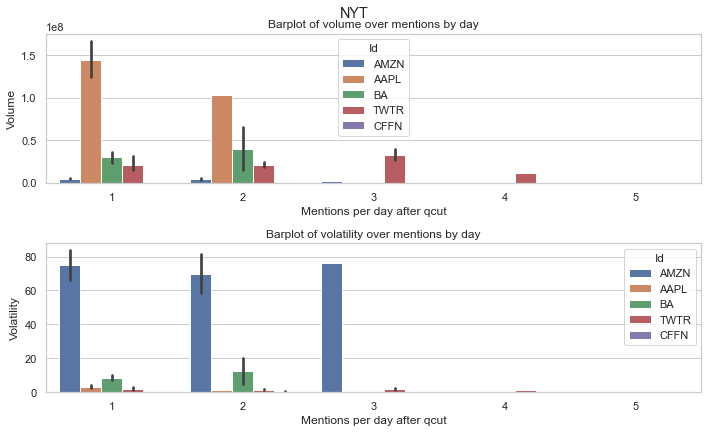

In [49]:
fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(211)
sns.barplot(data=df_nyt_merge, x='Mentions per day after qcut',
            y='Volume', hue="Id", ax=ax)
ax.set_title('Barplot of volume over mentions by day')

ax = plt.subplot(212)
sns.barplot(data=df_nyt_merge, x='Mentions per day after qcut',
            y='Volatility', hue="Id", ax=ax)
ax.set_title('Barplot of volatility over mentions by day')

plt.tight_layout()
plt.suptitle("NYT",y=1)
plt.show()

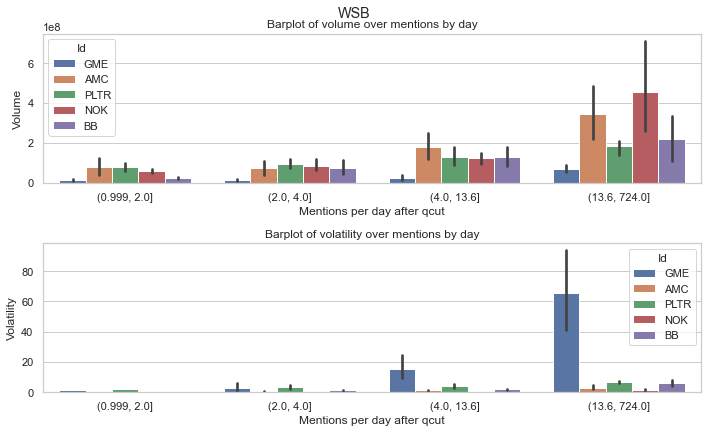

In [50]:
fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(211)
sns.barplot(data=df_wsb_merge, x='Mentions per day after qcut',
            y='Volume', hue="Id", ax=ax)
ax.set_title('Barplot of volume over mentions by day')

ax = plt.subplot(212)
sns.barplot(data=df_wsb_merge, x='Mentions per day after qcut',
            y='Volatility', hue="Id", ax=ax)
ax.set_title('Barplot of volatility over mentions by day')

plt.tight_layout()
plt.suptitle("WSB",y=1)
plt.show()

hypothesis test:

In [256]:
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests


#### Spearman Correlation Coefficient Test 
##### NYT:
Total time-series test:

In [83]:
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"], df_nyt_test.fillna(0).loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"]))

AAPL 0.05465977864777133 0.38757178734135656 252
AMZN -0.021667955995417133 0.732126464591049 252
BA 0.06378911434639706 0.3131598108641962 252
CFFN 0.04790149993644631 0.44900976774807233 252
TWTR 0.0393571281026692 0.5340011293896341 252


In [84]:
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"], df_nyt_test.fillna(0).loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"]))

AAPL -0.039906463004174796 0.5283039406341591 252
AMZN -0.028843671230003583 0.6486075261599225 252
BA 0.0832889606594161 0.18754086959908475 252
CFFN -0.08344137910451699 0.1867318757853582 252
TWTR 0.036591418958527126 0.5631449370402237 252


Time-series containing mentions per day > 1 test: 

In [103]:
print("Name", "Correlation", "p-value", "valid_length")
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volume"], df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volume"]))

Name Correlation p-value valid_length
AAPL -0.17903580300437075 0.45009791291219303 20
AMZN -0.023194237773259338 0.860367762970613 60
BA 0.04099600308453939 0.8801775191832785 16
CFFN -0.2723742144750883 0.16084526978229732 28
TWTR 0.24061776163969037 0.24661260072517688 25


In [86]:
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volatility"], df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volatility"]))

AAPL -0.37796447300922725 0.10036562194728639 20
AMZN -0.03605402454536795 0.7844785895698383 60
BA 0.04099600308453939 0.8801775191832785 16
CFFN -0.22863816461898684 0.24189573714958632 28
TWTR -0.11930354498309777 0.5700259191016658 25


##### WSB
Total time-series test:

In [98]:
for e in np.unique(df_wsb_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"], df_wsb_test.fillna(0).loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"]))

AMC 0.5840663522485632 1.9163902343143074e-24 252
BB 0.4726604542093796 1.9783749614728985e-15 252
GME 0.653092991871079 5.001131415157329e-32 252
NOK 0.4740297094305501 1.6010492603482326e-15 252
PLTR 0.4886130687537618 6.455945848631152e-09 126


In [99]:
for e in np.unique(df_wsb_test.index.get_level_values(1)):
    tmp = stats.spearmanr(df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"], df_wsb_test.fillna(0).loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"]))

AMC 0.495970655882509 4.72399709309768e-17 252
BB 0.46708427143768133 4.6384007103790205e-15 252
GME 0.7011678336977228 1.338944855140403e-38 252
NOK 0.3319650729552216 6.760698981176389e-08 252
PLTR 0.5873427078074595 4.867180512164519e-13 126


Time-series containing mentions per day > 1 test:

In [101]:
for e in np.unique(df_wsb_merge.index.get_level_values(1)):
    tmp = stats.spearmanr(df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volume"], df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volume"]))

AMC 0.6644015583559791 4.783920426975205e-07 46
BB 0.8650436536386003 4.92673415742807e-08 24
GME 0.7886981765543343 2.2936817919037983e-18 81
NOK 0.7544518368584803 2.273226786696202e-06 29
PLTR 0.43231917895042404 9.622532791132469e-05 76


In [102]:
for e in np.unique(df_wsb_merge.index.get_level_values(1)):
    tmp = stats.spearmanr(df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volatility"], df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]['Mentions per day'])
    print(e,tmp[0], tmp[1], len(df_wsb_merge.dropna().loc[pd.IndexSlice[:, e], :]["Volatility"]))

AMC 0.7072286196288846 3.919613951574334e-08 46
BB 0.917602237091976 2.787512531481612e-10 24
GME 0.887264746325344 2.8445799619134046e-28 81
NOK 0.7448236673607863 3.587940224264116e-06 29
PLTR 0.380643835530199 0.0006937701813937095 76


#### KS Test: 
Test whether mentions per day > 1 volume/volatility series has different distribution compared to mentions per day=0 volume/volatility series

NYT Volume KS Test:

In [92]:
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    arr1 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"][~np.isnan(df_nyt_test['Mentions per day'])]
    arr2 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"][np.isnan(df_nyt_test['Mentions per day'])]
    tmp = stats.kstest(arr1, arr2)
    print(e,tmp[0], tmp[1], len( df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"][~np.isnan(df_nyt_test['Mentions per day'])]), len( df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volume"][np.isnan(df_nyt_test['Mentions per day'])]))

AAPL 0.22327586206896552 0.27384996702614817 20 232
AMZN 0.09270833333333334 0.7902941378517688 60 192
BA 0.17796610169491525 0.6655344760356694 16 236
CFFN 0.14732142857142858 0.613570338482212 28 224
TWTR 0.15876651982378856 0.5610594251308143 25 227


NYT Volatility KS Test:

In [93]:
for e in np.unique(df_nyt_test.index.get_level_values(1)):
    arr1 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"][~np.isnan(df_nyt_test['Mentions per day'])]
    arr2 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"][np.isnan(df_nyt_test['Mentions per day'])]
    tmp = stats.kstest(arr1, arr2)
    print(e,tmp[0], tmp[1], len( df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"][~np.isnan(df_nyt_test['Mentions per day'])]), len( df_nyt_test.loc[pd.IndexSlice[:, e], :]["Volatility"][np.isnan(df_nyt_test['Mentions per day'])]))

AAPL 0.2267241379310345 0.25768544188037157 20 232
AMZN 0.12083333333333333 0.47780672702405125 60 192
BA 0.20233050847457626 0.5074077695662504 16 236
CFFN 0.17857142857142858 0.3722908356113033 28 224
TWTR 0.11242290748898678 0.9054233641229598 25 227


WSB Volume KS Test:

In [96]:
for e in np.unique(df_wsb_test.index.get_level_values(1)):
    arr1 = df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"][~np.isnan(df_wsb_test.loc[pd.IndexSlice[:, e], :]['Mentions per day'])]
    arr2 = df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"][np.isnan(df_wsb_test.loc[pd.IndexSlice[:, e], :]['Mentions per day'])]
    tmp = stats.kstest(arr1, arr2)
    print(e,tmp[0], tmp[1], len( df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"][~np.isnan(df_wsb_test['Mentions per day'])]), len( df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volume"][np.isnan(df_wsb_test['Mentions per day'])]))

AMC 0.7602363866610384 1.1102230246251565e-16 46 206
BB 0.8201754385964912 0.0 24 228
GME 0.6114359974009097 2.220446049250313e-16 81 171
NOK 0.7216638317612494 8.415490526658687e-14 29 223
PLTR 0.34 0.0012528844990202792 76 50


WSB Volatility KS Test:

In [97]:
for e in np.unique(df_wsb_test.index.get_level_values(1)):
    arr1 = df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"][~np.isnan(df_wsb_test.loc[pd.IndexSlice[:, e], :]['Mentions per day'])]
    arr2 = df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"][np.isnan(df_wsb_test.loc[pd.IndexSlice[:, e], :]['Mentions per day'])]
    tmp = stats.kstest(arr1, arr2)
    print(e,tmp[0], tmp[1], len( df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"][~np.isnan(df_wsb_test['Mentions per day'])]), len( df_wsb_test.loc[pd.IndexSlice[:, e], :]["Volatility"][np.isnan(df_wsb_test['Mentions per day'])]))

AMC 0.6270578303081469 1.3766765505351941e-14 46 206
BB 0.8421052631578947 0.0 24 228
GME 0.7115009746588694 2.220446049250313e-16 81 171
NOK 0.5223442090613886 5.370236817459073e-07 29 223
PLTR 0.5815789473684211 5.698687077781983e-10 76 50


## Test-Hypothesis-2 

### a. [2 points] Produce a time-series of (publication-time, entity-name, sentiment-index)-tuples by...
#### i. Choosing a Sentiment Analysis (SA) tool that is well suited for the specific dataset you are analyzing. You may want to try several and/or adjust the parameterization of the SA tool to see which performs the best.
A: WE chose TextBlob, Vader, zero-shot, fin-bert as our candidates.   
TextBlob is too simple to extract sentiment from financial news headlines accurately.  
Zero-shot runs too slow.  
Finally, we selected Vader and fin-bert.

#### ii. Explain which technique that SA tool uses
A: Vader and BERT.
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

#### iii. Explain why you found this to be a good tool-choice for each dataset.
A: We used some headlines as samples to test the accuracy of the models. And we found that these two models can extract sentiment from news headlines accurately in a resonable computational power.

#### TextBlob

In [107]:
from textblob import TextBlob

In [108]:
tb = TextBlob(nyt.loc[0,'title'])
tb.sentiment.polarity, tb.sentiment.subjectivity

(-0.1, 0.05)

In [109]:
def sa_textblob_polarity(txt):
    return TextBlob(txt).sentiment.polarity

In [110]:
txt = nyt.loc[0,'title']
txt, sa_textblob_polarity(txt)

('Human Rights Group Says Two U.S. Strikes Killed Somali Civilians', -0.1)

#### Vader

In [111]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Xiong\AppData\Roaming\nltk_data...


In [112]:
vad = SentimentIntensityAnalyzer().polarity_scores(nyt.loc[0,'title'])
vad

{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.7906}

In [113]:
def sa_vader_polarity(txt):
    return SentimentIntensityAnalyzer().polarity_scores(txt)['compound']

In [114]:
txt = nyt.loc[5,'title']
txt, sa_vader_polarity(txt)

('Trump Calls New Fuel Economy Rule a Boon. Some Experts See Steep Costs.',
 0.0)

### zero-shot

In [115]:
from transformers import pipeline

In [116]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)
Downloading: 100%|██████████| 1.13k/1.13k [00:00<00:00, 1.15MB/s]
Downloading: 100%|██████████| 1.52G/1.52G [02:26<00:00, 11.1MB/s]
Downloading: 100%|██████████| 26.0/26.0 [00:00<00:00, 26.0kB/s]
Downloading: 100%|██████████| 878k/878k [00:00<00:00, 3.98MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 3.77MB/s]
Downloading: 100%|██████████| 1.29M/1.29M [00:00<00:00, 4.25MB/s]


In [117]:
candidate_labels = ["positive", "negative"]
classifier(nyt.loc[0,'title'], candidate_labels)

{'sequence': 'Human Rights Group Says Two U.S. Strikes Killed Somali Civilians',
 'labels': ['negative', 'positive'],
 'scores': [0.9732742309570312, 0.026725728064775467]}

In [118]:
def sa_zero_shot(txt):
    return 2*(classifier(txt, candidate_labels)['scores'][1] - 0.5)


In [ ]:
txt = nyt.loc[0,'title']
txt, sa_zero_shot(txt)

('Human Rights Group Says Two U.S. Strikes Killed Somali Civilians',
 -0.9465485438704491)

### Finbert

In [227]:
sa_finbert_scorer = pipeline("sentiment-analysis",model="ProsusAI/finbert")

In [229]:
def sa_finbert(txt):
    d = {"negative":-1, "neutral":0, "positive":1}
    res = sa_finbert_scorer(txt)[0]
    return d[res["label"]]*res["score"]

In [254]:
nyt.loc[0,'title'], sa_finbert(nyt.loc[0,'title'])

('Human Rights Group Says Two U.S. Strikes Killed Somali Civilians',
 -0.9017682671546936)

### b. [3 points] For 5 corporations on which your NER and SA performed well, identify and measure the following time series:
A: Written in code explanation of function hypothesis_test() preprocessing part. See code comments there in detail.

### c. [5 points] Does the data support hypothesis-2


A: 
For P/N Mentions, we define P/N rates as 
$$\frac{Positive Mentions + 1}{Negative Mentions + 1}$$
 to avoid divide 0, and Positive Mentions=0 and Negative Mentions $\neq$ 0 situation.

We will do the following tests to test the relationship between return direction and P/N Mentions:  
- 1. Spearman Test: we caculate corr(return_direction, P/N Mentions) and test the t-statistics of spearman corr  
- 2. KS-Test: We test the hypothesis that return_direction[P/N Mentions == 1] follows the same distribution as return_direction[P/N Mentions != 1]  
- 3. Granger Causality-Test: We test the hypothesis that P/N Mentions has impact on return_direction  
- 4. Kruskal-Test: Similar to KS-Test.  

### Conclusion on hypothesis test 2
Our credential level set as $\alpha=1\% $.
Here our null hypothesis is that: The P/N Mentions is uncorrelated with the direction of movement in the related corporation's stock.
or 
The P/N Mentions has no impact on the direction of movement in the related corporation's stock.

In the following table, $A$ represents that the null hypothesis is accepted for all selected stocks, and $R$ represents that the null hypothesis is rejected for all selected stocks. 

| Test Type | NYT | WSB |
| :-----: | :----: | :----: |
| Spearman Test |  $A$ |  $A$ |
| KS-Test |  $A$ |  $A$ |
| Granger Causality-Test |  $A$ |  $A$ |
| Kruskal-Test |  $A$ |  $A$ |

So we can conclude that in both NYT Dataset and WSB Dataset, under our credential level $\alpha$, for our selected stocks, The P/N Mentions is uncorrelated with the direction of movement in the related corporation's stock.

In [121]:
def recognize_entity(df, iter_method=entities, sa_method=None):

    entity_list = []
    entity_label_list = []
    datetime_list = []
    sentiment_list = []

    for index in tqdm(df.index):
        # print(df.loc[index, 'created_utc_dt'])
        datetime = df.loc[index, 'created_utc_dt'].split(' ')[0]
        txt = df.loc[index, 'title']
        doc = nlp(txt)

        sentiment = None
        if sa_method:
            sentiment = sa_method(txt)

        for entity in iter_method(doc):
            entity_list.append(entity.text)
            entity_label_list.append(entity.label_)
            datetime_list.append(datetime)
            sentiment_list.append(sentiment)

    return pd.DataFrame({'Entity': entity_list, 'Entity_label': entity_label_list, 'Date': datetime_list, 'Sentiment': sentiment_list})


In [251]:
def hypothesis_test(df, iter_method, sa_mathod, stock_data, selected_entities=nyt_selected_entities, title="NYT"):
    """
    Given the parameters, this function will plot the Barplots of return and return_direction. over P/N Mentions.
    
    For P/N Mentions, we define it as (Positive Mentions + 1)/(Negative Mentions + 1).

    Also, this function will do the following tests to test the relationship between return direction and P/N Mentions:
        1. Spearman Test: we caculate corr(return_direction, P/N Mentions) and test the t-statistics of spearman corr
        2. KS-Test: We test the hypothesis that return_direction[P/N Mentions == 1] follows the same distribution as return_direction[P/N Mentions != 1]
        3. Granger Causality-Test: We test the hypothesis that P/N Mentions has impact on return_direction
        4. Kruskal-Test: Similar to KS-Test.
    
    Params:
    df: DataFrame contains columns ['Date', 'Headlines']. Date should in the format of %Y-%m-%d, with str type.
    iter_method: should be textacy.extract.entities
    sa_method: function turn str to sentiment score
    stock_data: DataFrame contains the price-volume data of selected stocks
    selected_entities: selected stocks
    title: plot title. "NYT" for NYT dataset; "WSB" for WSB dataset.

    Return: DataFrame
        DataFrame contains sentiment analysis result
    """
    ### Preprocessing data
    nyt_stock_data = stock_data
    nyt_selected_entities = selected_entities
    df_nyt_entity = recognize_entity(df, iter_method, sa_mathod)
    df_nyt_entity = df_nyt_entity[df_nyt_entity['Entity_label'].isin(['ORG','PRODUCT'])]
    df_nyt_entity['Positive Mentions'] = (df_nyt_entity['Sentiment']>0)*1
    df_nyt_entity['Negative Mentions'] =(df_nyt_entity['Sentiment']<0)*1
    df_nyt = df_nyt_entity[df_nyt_entity['Entity'].isin(nyt_selected_entities)]
    if title=="NYT":
        df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])
    df_nyt = df_nyt.groupby(['Entity','Date'])[['Positive Mentions','Negative Mentions']].sum() # b(i)&b(ii). Get positive/Negative Mentions per day
    df_nyt['P/N Mentions'] = (df_nyt['Positive Mentions']+1)/(df_nyt['Negative Mentions']+1)
    df_nyt['P-N Mentions'] = df_nyt['Positive Mentions']-df_nyt['Negative Mentions']
    df_nyt = df_nyt.swaplevel()
    df_nyt = df_nyt.sort_index(level=['Date','Entity'])
    
    df_nyt_merge = df_nyt.copy()
    df_nyt_merge['return'] = (nyt_stock_data['Close'] - nyt_stock_data['Open'])/nyt_stock_data['Open']# b(iii). Get Daily stock return.
    df_nyt_merge['return_direction'] = np.sign(df_nyt_merge['return'])
    df_nyt_merge['Id'] = df_nyt_merge.index.get_level_values(level='Entity')

    df_nyt_test = nyt_stock_data.copy()
    df_nyt_test['return'] = (nyt_stock_data['Close'] - nyt_stock_data['Open'])/nyt_stock_data['Open']
    df_nyt_test['return_direction'] = np.sign(df_nyt_test['return'])
    df_nyt_test["Positive Mentions"] = df_nyt["Positive Mentions"]
    df_nyt_test["Negative Mentions"] = df_nyt["Negative Mentions"]
    df_nyt_test = df_nyt_test.fillna(0)
    df_nyt_test["P/N Mentions"] = (df_nyt_test['Positive Mentions']+1)/(df_nyt_test['Negative Mentions']+1)

    ### Plot  
    fig = plt.figure(figsize=(16, 10))

    ax = plt.subplot(211)
    sns.barplot(data=df_nyt_merge, x='P/N Mentions',
                y='return', hue="Id", ax=ax)
    ax.set_title('Barplot of return over P/N Mentions')

    ax = plt.subplot(212)
    # sns.barplot(data=df_wsb_merge, x='P/N Mentions after qcut',
    #             y='return_direction', hue="Id", ax=ax)
    sns.barplot(data=df_nyt_merge, x='P-N Mentions',
                y='return', hue="Id", ax=ax)
    ax.set_title('Barplot of return direction over P/N Mentions')

    plt.tight_layout()
    plt.suptitle(title,y=1)
    plt.show()

    ### Hypothesis Test
    print("\n","="*30, title, " P/N Mentions and return_direction spearman corr t test:", "="*30)
    for e in np.unique(df_nyt_merge.index.get_level_values(1)):
        tmp = stats.spearmanr(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["P/N Mentions"], df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["return_direction"])
        print(e,tmp[0], tmp[1], len(df_nyt_merge.dropna().loc[pd.IndexSlice[:, e], :]["P/N Mentions"]))

    print("\n","="*30, title, " P/N Mentions and return_direction ks-test:", "="*30)
    for e in np.unique(df_nyt_test.index.get_level_values(1)):
        arr1 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["return_direction"][df_nyt_test['P/N Mentions']==1]
        arr2 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["return_direction"][df_nyt_test['P/N Mentions']!=1]
        tmp = stats.kstest(arr1, arr2)
        print(e,tmp[0], tmp[1], len(arr1), len(arr2))
    
    print("\n","="*30, title, " P/N Mentions to return_direction granger causality-test:","="*30)
    for e in np.unique(df_nyt_test.index.get_level_values(1)):
        df_tmp = df_nyt_test.loc[pd.IndexSlice[:, e], :]
        tmp = grangercausalitytests(df_tmp[['return_direction', 'P/N Mentions']], maxlag=2)
        print(e,len(df_tmp))
    
    print("\n","="*30, title, " P/N Mentions to return_direction kruskal-test:","="*30)
    for e in np.unique(df_nyt_test.index.get_level_values(1)):
        arr1 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["return_direction"][df_nyt_test['P/N Mentions']==1]
        arr2 = df_nyt_test.loc[pd.IndexSlice[:, e], :]["return_direction"][df_nyt_test['P/N Mentions']!=1]
        tmp = stats.kruskal(arr1, arr2)
        print(e,tmp[0], tmp[1], len(arr1), len(arr2))

    return df_nyt_entity

#### NYT Dataset

100%|██████████| 57937/57937 [03:02<00:00, 316.65it/s]
C:\Users\Xiong\AppData\Local\Temp/ipykernel_10588/1801480120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])


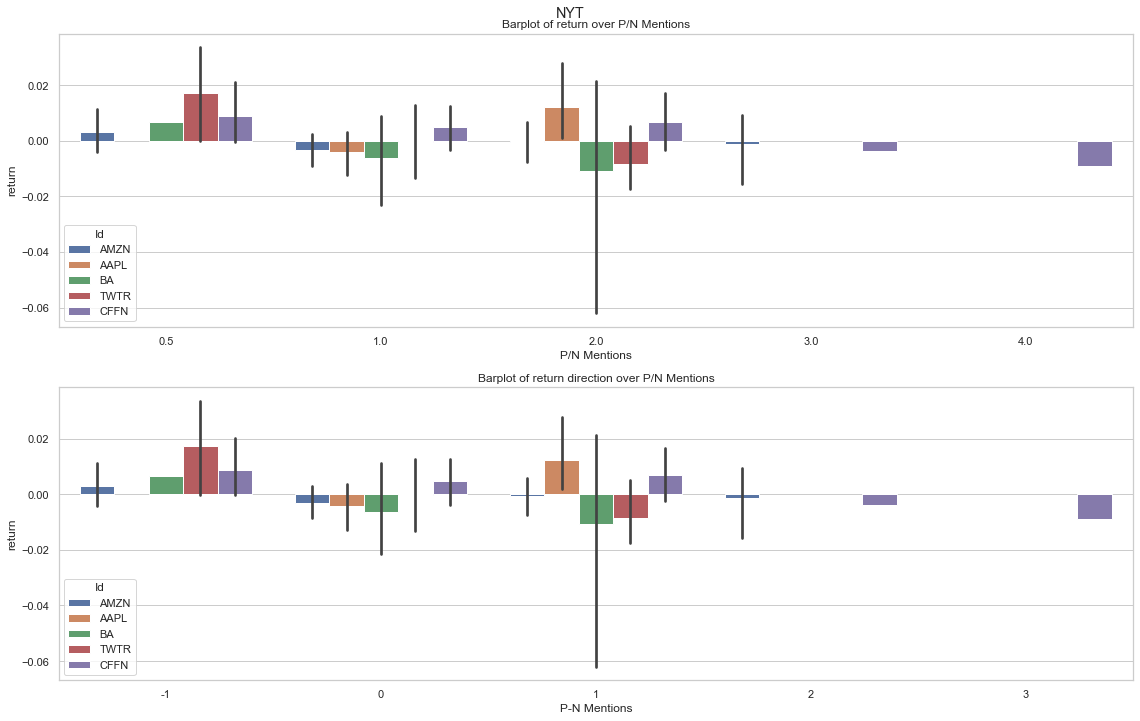

NYT  P/N Mentions and return_direction spearman corr t test:
AAPL 0.20100756305184245 0.3954505048485982 20
AMZN 0.1391853118667475 0.2888633749185414 60
BA 0.20158105227158785 0.4540657375444228 16
CFFN -0.24064554629745136 0.2173719643281393 28
TWTR -0.2716428657578167 0.1890010046487291 25
NYT  P/N Mentions and return_direction ks-test:
AAPL 0.21774193548387097 0.9750053143707442 248 4
AMZN 0.08396474408535642 0.9854896400108307 223 29
BA 0.38299595141700404 0.36906259317353385 247 5
CFFN 0.16806722689075632 0.7999250924611949 238 14
TWTR 0.14549180327868852 0.9878613172011148 244 8
NYT  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0463  , p=0.3073  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=1.0590  , p=0.3034  , df=1
likelihood ratio test: chi2=1.0568  , p=0.3040  , df=1
parameter F test:         F=1.0463  , p=0.3073  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero)

,Entity,Entity_label,Date,Sentiment,Positive Mentions,Negative Mentions
0,Human Rights Group,ORG,2020-04-01,-0.100000,0,1
8,Kennedy Center Defends Use,ORG,2020-04-01,-0.100000,0,1
12,Trump Calls New Fuel Economy Rule a Boon,ORG,2020-04-01,0.136364,1,0
16,Jazz Trumpet Virtuoso,ORG,2020-04-01,-0.200000,0,1
18,Coronavirus,ORG,2020-04-01,0.000000,0,0
...,...,...,...,...,...,...
77303,Weaken Citizen’s,ORG,2021-03-31,-0.050000,0,1
77315,Biden’s Big Bet:,ORG,2021-03-31,0.000000,0,0
77320,Biden Unveils Infrastructure Plan,ORG,2021-03-31,0.000000,0,0
77321,Biden,ORG,2021-03-31,0.000000,0,0


In [242]:
df1 = hypothesis_test(nyt, entities, sa_textblob_polarity, nyt_stock_data, title="NYT")

100%|██████████| 57937/57937 [07:09<00:00, 134.79it/s]
C:\Users\Xiong\AppData\Local\Temp/ipykernel_10588/2941447740.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])


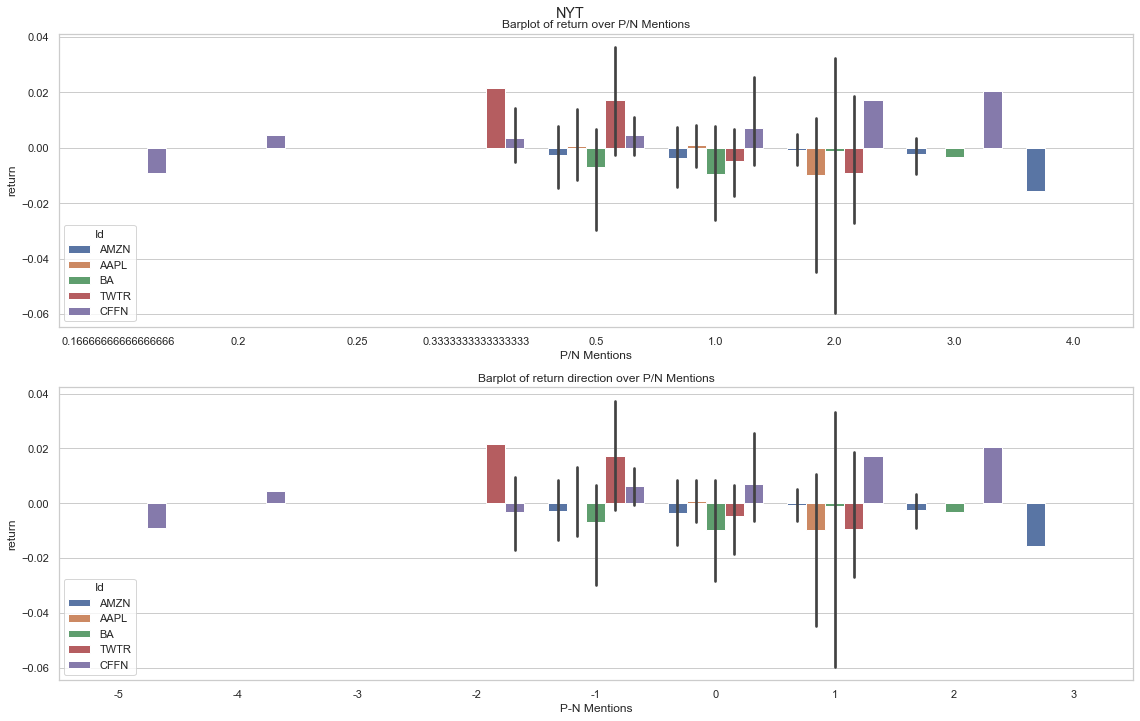


NYT  P/N Mentions and return_direction spearman corr t test:
AAPL 0.019121909540392504 0.9362242679082368 20
AMZN 0.04723471945483715 0.7200573987546652 60
BA 0.0 1.0 16
CFFN 0.0699966037974731 0.7233875719053631 28
TWTR -0.24863317519148076 0.23074077203151555 25

NYT  P/N Mentions and return_direction ks-test:
AAPL 0.06694214876033058 0.9999999954793243 242 10
AMZN 0.02178126442085833 1.0 197 55
BA 0.2069672131147541 0.8331264577665214 244 8
CFFN 0.24780701754385964 0.11790256039834202 228 24
TWTR 0.0411522633744856 1 243 9

NYT  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0292  , p=0.8645  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=0.0295  , p=0.8635  , df=1
likelihood ratio test: chi2=0.0295  , p=0.8635  , df=1
parameter F test:         F=0.0292  , p=0.8645  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7483  , p=0.4743  , df_den

In [262]:
df2 = hypothesis_test(nyt, entities, sa_vader_polarity, nyt_stock_data, title="NYT")

100%|██████████| 57937/57937 [35:33<00:00, 27.16it/s]
C:\Users\Xiong\AppData\Local\Temp/ipykernel_10588/1801480120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt['Entity'] = df_nyt['Entity'].apply(lambda x: name_symbol_match[x])


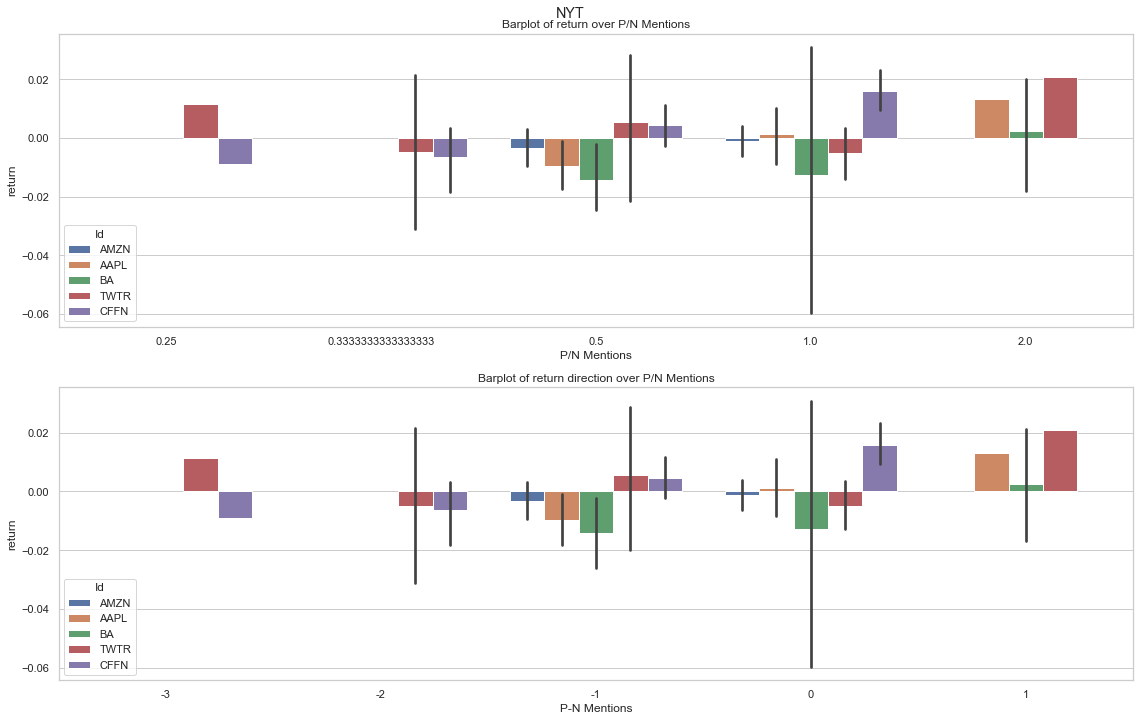

NYT  P/N Mentions and return_direction spearman corr t test:
AAPL 0.22825412775410864 0.33308686410701216 20
AMZN 0.0986191147361373 0.45345878551812924 60
BA 0.3070441243145588 0.24736901771900907 16
CFFN 0.5465199076223226 0.002620797384441223 28
TWTR -0.1535728519789731 0.4636088033733291 25
NYT  P/N Mentions and return_direction ks-test:
AAPL 0.036585365853658534 1 246 6
AMZN 0.1282051282051282 0.9202529933926191 234 18
BA 0.0125 1 240 12
CFFN 0.09523809523809523 0.9895414415151369 231 21
TWTR 0.07083333333333333 0.9999997779937302 240 12
NYT  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3710  , p=0.5430  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=0.3755  , p=0.5400  , df=1
likelihood ratio test: chi2=0.3752  , p=0.5402  , df=1
parameter F test:         F=0.3710  , p=0.5430  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3817  , p=0

In [244]:
df3 = hypothesis_test(nyt, entities, sa_finbert, nyt_stock_data, title="NYT")

#### WSB Dataset

100%|██████████| 50000/50000 [06:29<00:00, 128.49it/s]


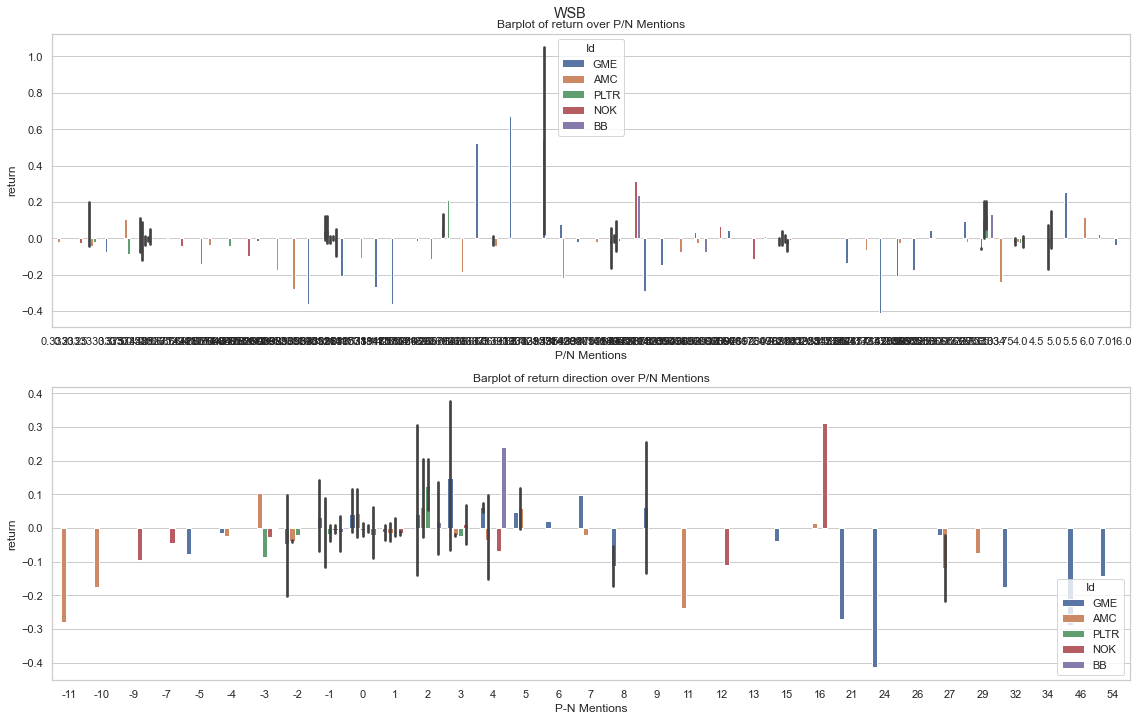


WSB  P/N Mentions and return_direction spearman corr t test:
AMC -0.05898971924428021 0.6969680448760566 46
BB -0.07017752347098574 0.7503458612744718 23
GME -0.11417326901269483 0.31014793728549545 81
NOK 0.041833766898901434 0.829403814669162 29
PLTR 0.2116223022044573 0.07228645145098576 73

WSB  P/N Mentions and return_direction ks-test:
AMC 0.0720609936055091 0.9908111957591068 214 38
BB 0.09166666666666666 0.9998206790575311 240 12
GME 0.08128342245989305 0.8752587364939374 187 65
NOK 0.23469618251637678 0.24468487717075826 233 19
PLTR 0.11655926029700196 0.7794060725683185 83 43

WSB  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6173  , p=0.4328  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=0.6248  , p=0.4293  , df=1
likelihood ratio test: chi2=0.6240  , p=0.4296  , df=1
parameter F test:         F=0.6173  , p=0.4328  , df_denom=248, df_num=1

Granger Causality
number of lags (no zer

In [261]:
df4 = hypothesis_test( wsb25.sample(n=50000, replace=False, random_state=1) , entities, sa_vader_polarity, wsb_stock_data, selected_entities=wsb_selected_entities, title="WSB")

100%|██████████| 50000/50000 [32:18<00:00, 25.79it/s]


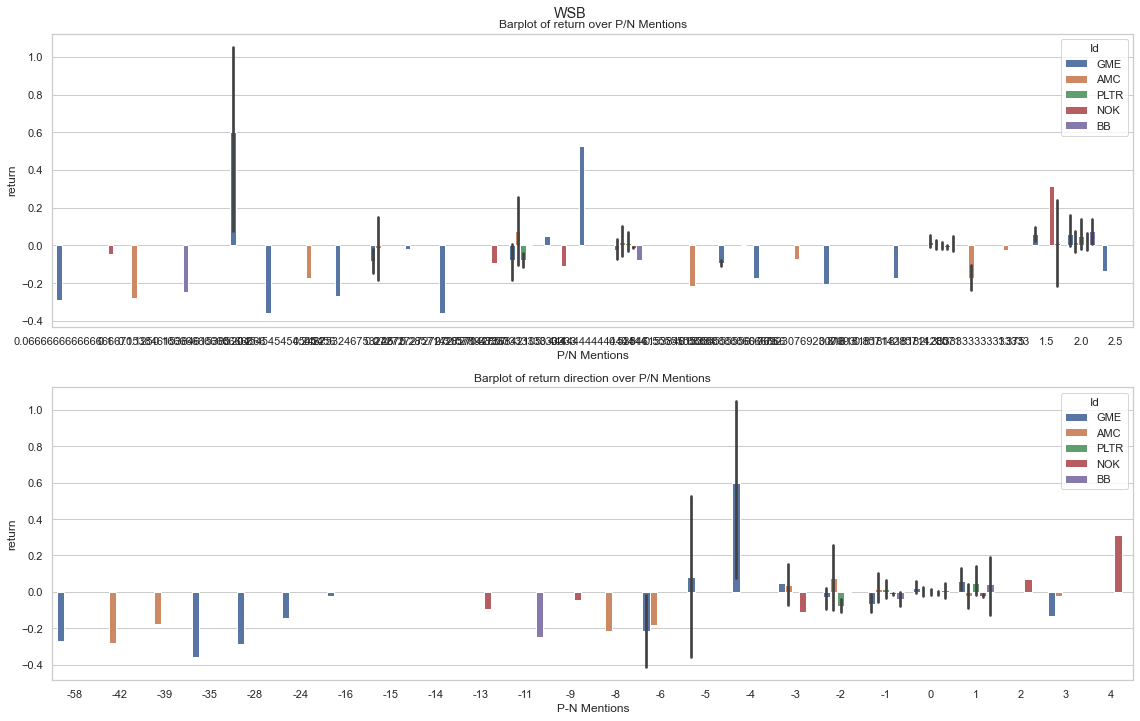


WSB  P/N Mentions and return_direction spearman corr t test:
AMC 0.012718322323979115 0.9331444742416587 46
BB 0.4109186690257021 0.05143586093747507 23
GME 0.12189671992661673 0.27833486514974887 81
NOK 0.2016781525332879 0.29412037842846217 29
PLTR 0.05010287924385763 0.6737878068587865 73

WSB  P/N Mentions and return_direction ks-test:
AMC 0.11422924901185771 0.9267620697097227 230 22
BB 0.024489795918367346 1 245 7
GME 0.07833537331701346 0.9659928107964226 209 43
NOK 0.18760330578512396 0.8273264400432352 242 10
PLTR 0.06591244466305952 0.9999908156712267 107 19

WSB  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0545  , p=0.8155  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=0.0552  , p=0.8142  , df=1
likelihood ratio test: chi2=0.0552  , p=0.8142  , df=1
parameter F test:         F=0.0545  , p=0.8155  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F t

In [255]:
df5 = hypothesis_test( wsb25.sample(n=50000, replace=False, random_state=1) , entities, sa_finbert, wsb_stock_data, selected_entities=wsb_selected_entities, title="WSB")


100%|██████████| 50000/50000 [02:42<00:00, 307.24it/s]


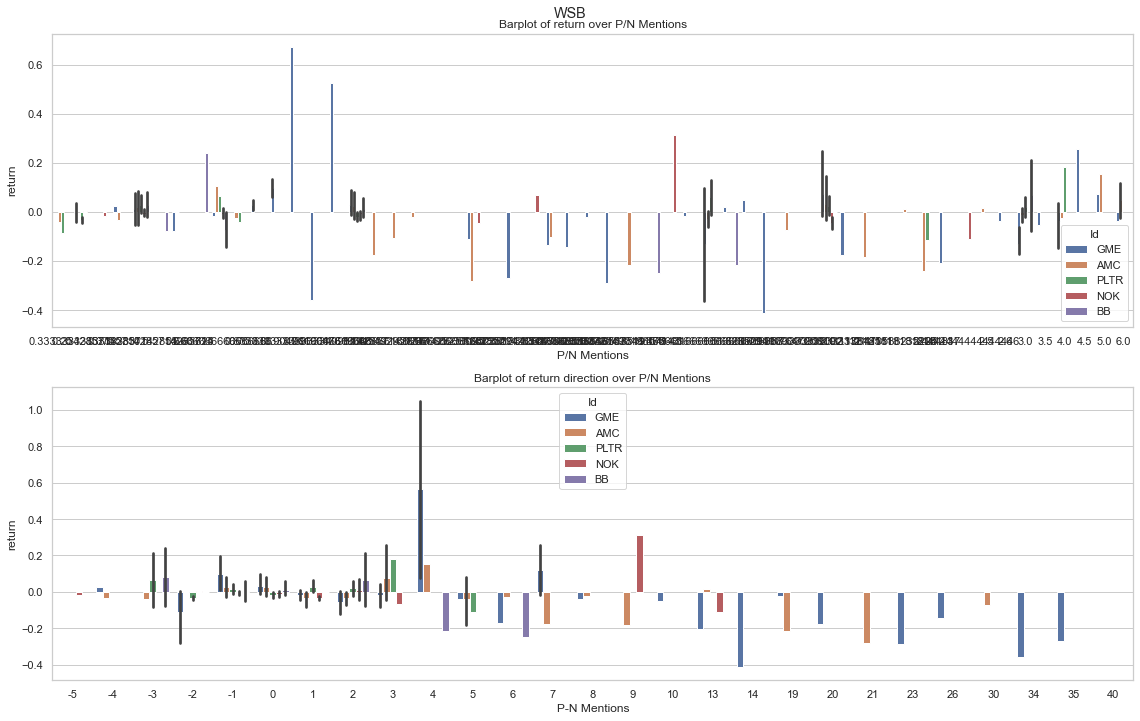

WSB  P/N Mentions and return_direction spearman corr t test:
AMC -0.006755784611215398 0.9644584723996911 46
BB -0.27690393515925227 0.2008565873017157 23
GME -0.20123362640421702 0.07163520645698182 81
NOK -0.11439491702532179 0.5545989038150454 29
PLTR 0.13657935214706976 0.24923796409041743 73
WSB  P/N Mentions and return_direction ks-test:
AMC 0.05092592592592592 0.9999921381776786 216 36
BB 0.026483050847457626 1 236 16
GME 0.10104166666666667 0.6985850566858579 192 60
NOK 0.1581196581196581 0.7500679027745342 234 18
PLTR 0.17239467849223947 0.31648716759744966 82 44
WSB  P/N Mentions to return_direction granger causality-test:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9474  , p=0.1641  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=1.9710  , p=0.1603  , df=1
likelihood ratio test: chi2=1.9633  , p=0.1612  , df=1
parameter F test:         F=1.9474  , p=0.1641  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F

In [250]:
df6 = hypothesis_test( wsb25.sample(n=50000, replace=False, random_state=1) , entities, sa_textblob_polarity, wsb_stock_data, selected_entities=wsb_selected_entities, title="WSB")

## Results and Conclusions

### Conclusion of Hypothesis Test 1
Our credential level set as $\alpha=1\% $.

### For NYT Dataset:
For spearman correlation test, we constructed two kinds of time series.
- Firstly, we set the Mentions per day as 0 if there is no mention of the stock that day. Then, we calculate the spearman correlation and its t-statistics. We find that for all 5 stocks we selected, we cannot reject the null hypothesis that Mentions per day has correlation with stock volume or volatility.
- Secondly, we only selected dates with Mentions per day > 1. And the conclusion is the same.

For KS-Test, we want to test the null hypothesis that Volume(Volatitlity) in dates, which has Mentions per day > 0, follows the same distribution as Volume(Volatility) in dates, which has Mentions per day=0. Again, we cannot reject the null hypothesis for volume and volatility.  
So in NYT Dataset, the frequency of mentions of a corporate entity is not correlated with trading activity of that corporation's stock under our selected securities and credential level $\alpha$.

### For WSB Dataset:
We use the same tests as NYT Dataset.

For spearman correlation test:
- First time series, we reject the null hypothesis for both volume and volatility.
- Second time series, we reject the null hypothesis for both volume and volatility as well.

For KS-Test, we reject the null hypothesis for both volume and volatility, too.  
So in WSB Dataset, the frequency of mentions of a corporate entity is correlated with trading activity of that corporation's stock under our selected securities and credential level $\alpha$.

### Conclusion on hypothesis test 2
For P/N Mentions, we define P/N Mentions as 
$$P/NMentions = \frac{Positive Mentions + 1}{Negative Mentions + 1}$$
 to avoid divide 0, and Positive Mentions=0 and Negative Mentions $\neq$ 0 situation.

We will do the following tests to test the relationship between return direction and P/N Mentions:  
- 1. Spearman Test: we caculate corr(return_direction, P/N Mentions) and test the t-statistics of spearman corr  
- 2. KS-Test: We test the hypothesis that return_direction[P/N Mentions == 1] follows the same distribution as return_direction[P/N Mentions != 1]  
- 3. Granger Causality-Test: We test the hypothesis that P/N Mentions has impact on return_direction  
- 4. Kruskal-Test: Similar to KS-Test.  

Our credential level set as $\alpha=1\% $.
Here our null hypothesis is that: The P/N Mentions is uncorrelated with the direction of movement in the related corporation's stock.
or 
The P/N Mentions has no impact on the direction of movement in the related corporation's stock.

In the following table, $A$ represents that the null hypothesis is accepted for all selected stocks, and $R$ represents that the null hypothesis is rejected for all selected stocks. 

| Test Type | NYT | WSB |
| :-----: | :----: | :----: |
| Spearman Test |  $A$ |  $A$ |
| KS-Test |  $A$ |  $A$ |
| Granger Causality-Test |  $A$ |  $A$ |
| Kruskal-Test |  $A$ |  $A$ |

So we can conclude that in both NYT Dataset and WSB Dataset, under our credential level $\alpha$, for our selected stocks, The P/N Mentions is uncorrelated with the direction of movement in the related corporation's stock.